In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

14


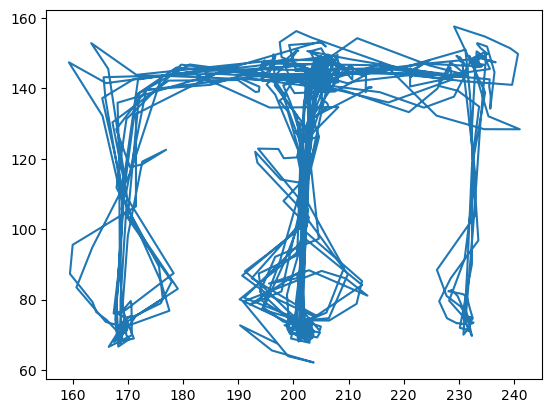

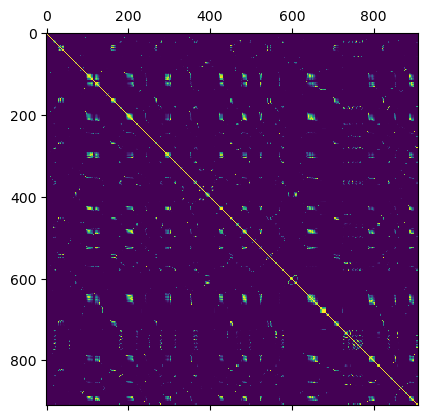

In [65]:
mouse_name = 'Fiv'
day = 5
epoch = 2

z_true, x = datasets.hc_6(mouse_name, day, epoch)
n_points, d_latent = z_true.shape
print(x.shape[1])
plt.plot(z_true[:, 0], z_true[:, 1])
cov_true = utils.kernel_cov_generator(z_true)
plt.matshow(cov_true)

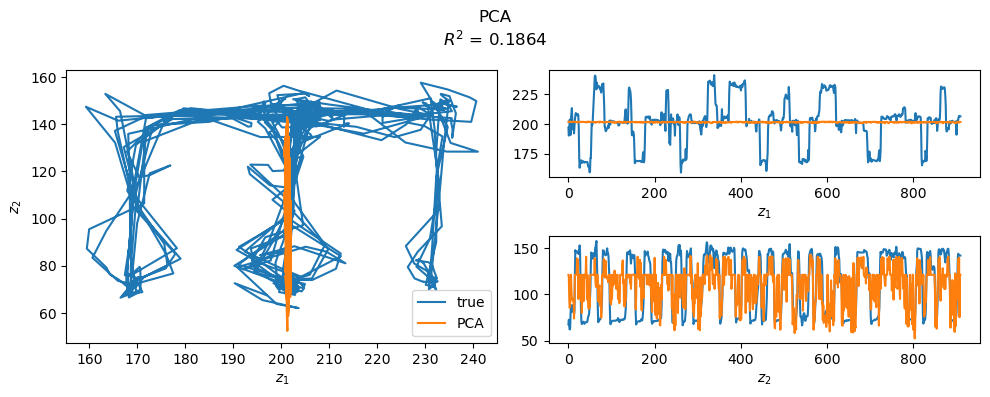

In [66]:
z_pca = PCA(n_components=d_latent).fit_transform(x**0.1)
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), 'PCA')

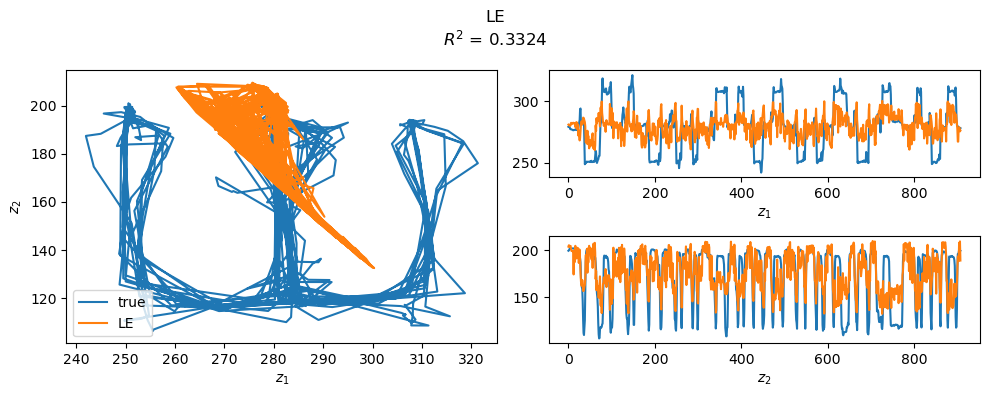

In [209]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x**0.1)
evaluate.compare_latents(z_true, utils.align(z_true, z_le), 'LE')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


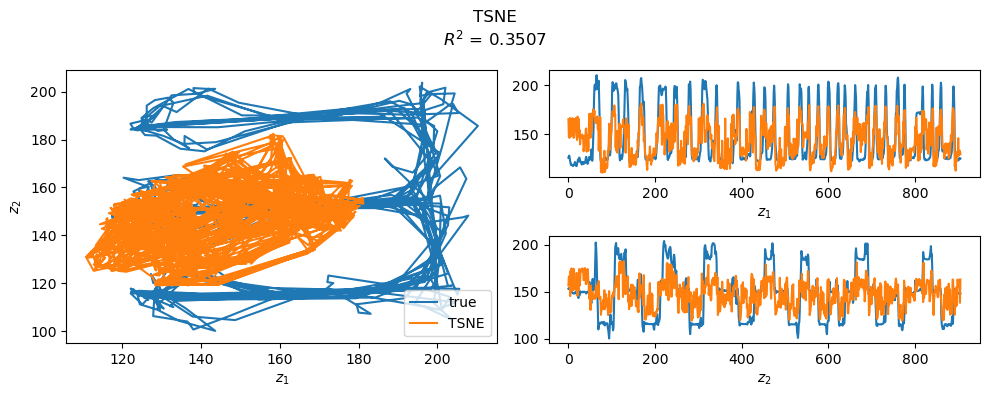

In [183]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), 'TSNE')

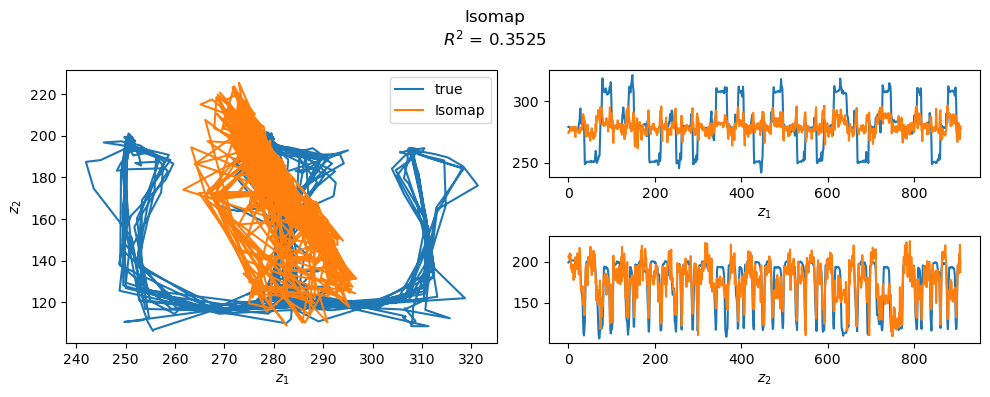

In [210]:
z_isomap = Isomap(n_components=d_latent).fit_transform(x**0.1)
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), 'Isomap')

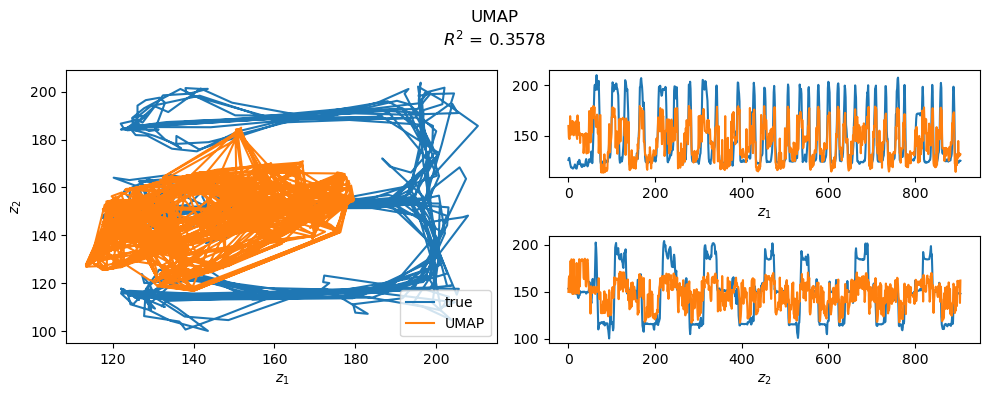

In [186]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), 'UMAP')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


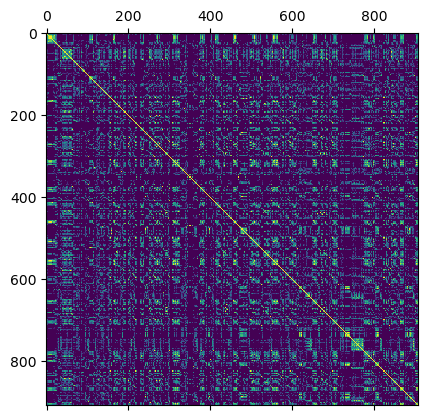

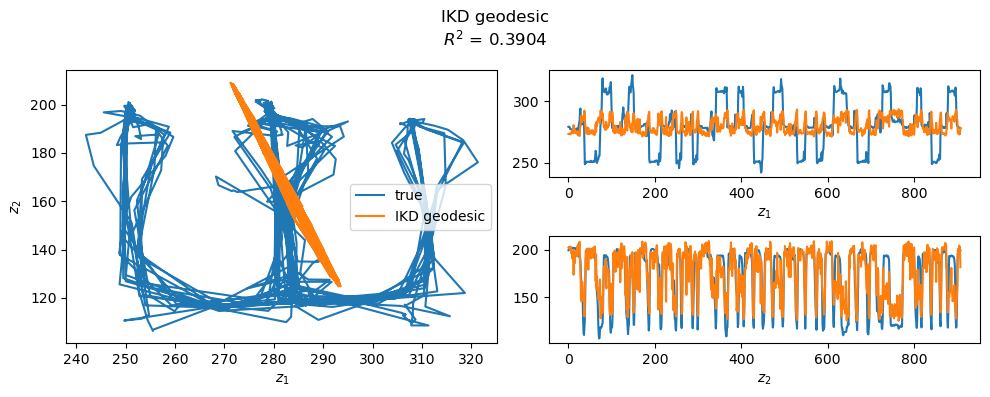

In [217]:
corr_samp = np.corrcoef(x**0.1)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 1e-3] = 1e-3
np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
np.fill_diagonal(corr_samp_th, 1)
plt.matshow(corr_samp_th)

a = -np.log(corr_samp_th)
a_new = np.zeros((n_points, n_points))
np.fill_diagonal(a, 1e5)
for i in range(n_points):
    idx = np.argpartition(a[i], 30)[:30]
    a_new[i, idx] = a[i, idx]
    a_new[idx, i] = a[idx, i]
d = shortest_path(csr_matrix(a_new), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD geodesic')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


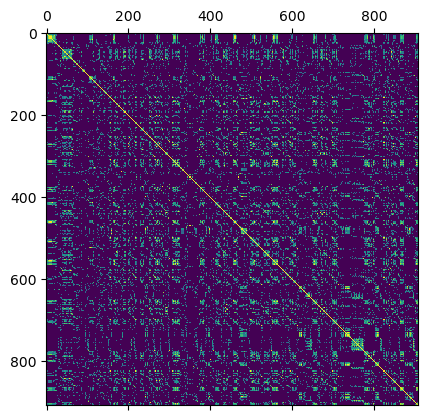

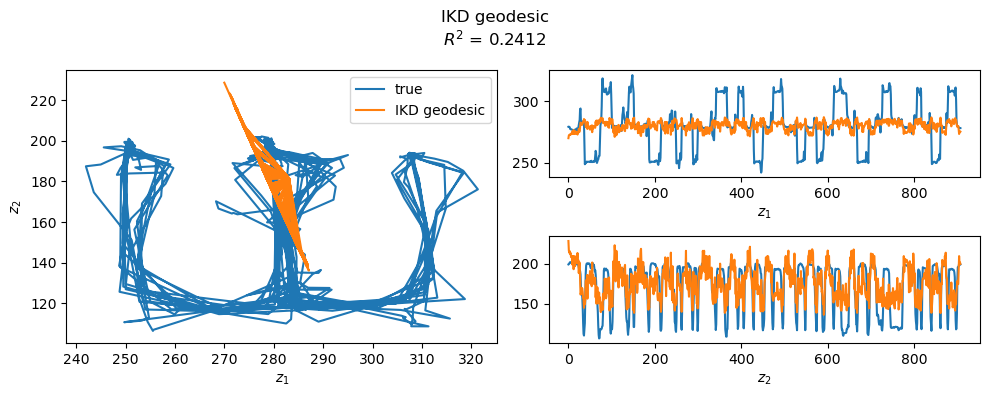

In [221]:
corr_samp = np.corrcoef(x**0.1)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 0.3] = 1e-3
np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
np.fill_diagonal(corr_samp_th, 1)
plt.matshow(corr_samp_th)

d = shortest_path(csr_matrix(-np.log(corr_samp_th)), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD geodesic')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Only one clique, identical to full eigen-decomposition


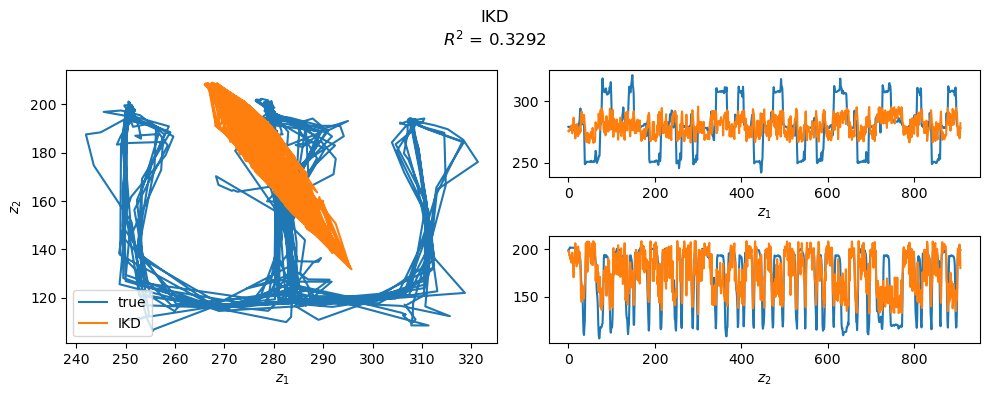

In [216]:
z_ikd = core.ikd_blockwise(x**0.1, d_latent=d_latent, clique_th=0)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD')